In [0]:
import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score
#from pyproj import Proj,transform
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler

!pip install bayesian-optimization

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score   # AUC 스코어 계산
from sklearn.metrics import accuracy_score,log_loss,f1_score
from sklearn.model_selection import KFold,StratifiedKFold   # K-fold CV    
from sklearn.metrics import classification_report
from bayes_opt import BayesianOptimization  # 베이지안 최적화 라이브러리  
from functools import partial               # 함수 변수 고정
import lightgbm as lgb                      # LightGBM 라이브러리
import warnings       
warnings.filterwarnings("ignore")
import numpy as np
from imblearn.over_sampling import SMOTE

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


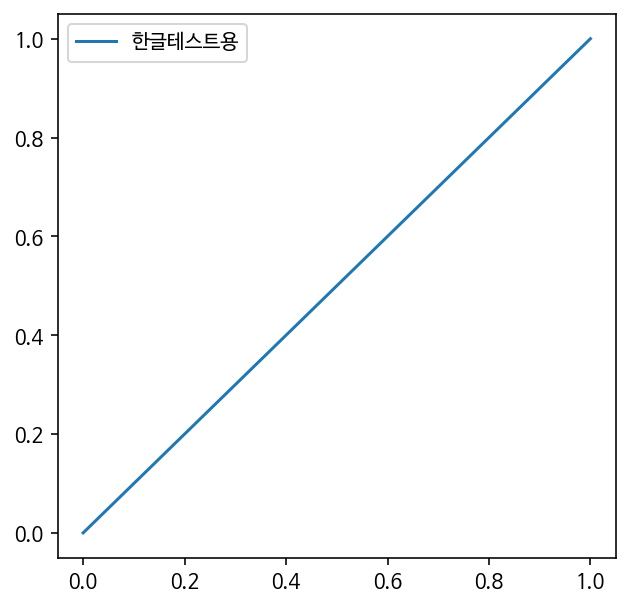

In [0]:
plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], label='한글테스트용')
plt.legend()
plt.show()

# 직사각형: 10만, 유클리드:150

In [0]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/공모전/동작구_공모전/sell_십만_150.csv',encoding='cp949')
data.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)

In [0]:
# 파생변수 제작
data['old/building'] = data['old_place']/data['building']
data['child/building'] = data['child_place']/data['building']

In [0]:
data.head()

,x,y,소로,중로2류,소로1류,소로3류,중로3류,소로2류,중로1류,광로2류,old_place,child_place,crosswork,building,bus,bohang,accident,old_acc,old/building,child/building
0,195600.888993,545928.299315,6,0,0,1,0,0,0,0,0.0,1.0,5.0,93.0,45.0,0.0,0.0,0.0,0.000000,0.010753
1,194062.308207,544725.091085,19,0,0,1,0,0,0,0,1.0,3.0,4.0,219.0,2.0,0.0,2.0,1.0,0.004566,0.013699
2,197377.867009,543986.683138,0,0,0,0,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,193058.182323,543489.087262,0,0,0,0,0,0,0,0,0.0,1.0,1.0,14.0,0.0,0.0,0.0,0.0,0.000000,0.071429
4,197347.383013,542701.828076,23,0,0,3,0,0,0,0,4.0,2.0,3.0,258.0,4.0,0.0,1.0,1.0,0.015504,0.007752


In [0]:
# 이진분류
data.loc[data['old_acc']==0,'accident']=0
data.loc[data['old_acc']!=0,'accident']=1

In [0]:
X_train=data.drop(['x','y','accident','building','old_place','child_place','child/building','old_acc'],axis=1)
y_train=data['accident']

In [0]:
X_train.replace([np.inf, -np.inf], 0, inplace=True)
X_train.fillna(0,inplace=True)
#X_test.replace([np.inf, -np.inf], 0, inplace=True)
#X_test.fillna(0,inplace=True)

In [0]:
def lgb_cv(num_leaves, learning_rate, n_estimators, subsample, colsample_bytree, reg_alpha,reg_lambda, x_data=None, y_data=None, n_splits=5, output='model'):
    score = 0
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=201)
    models = []
    sm = SMOTE(ratio='auto', kind='regular')
    for train_index, valid_index in skf.split(x_data,y_data):
       #print(train_index)
       x_train, y_train = x_data.iloc[train_index], y_data.iloc[train_index]
       
       #Smote
       sm = SMOTE(ratio='auto', kind='regular')
       # train데이터를 넣어 복제함
       X_resampled, y_resampled = sm.fit_sample(x_train,y_train)
       x_valid, y_valid = x_data.iloc[valid_index], y_data.iloc[valid_index]
        
       model = lgb.LGBMClassifier(
               
           num_leaves = int(num_leaves), 
           learning_rate = learning_rate, 
           n_estimators = int(n_estimators), 
           subsample = np.clip(subsample, 0, 1), 
           colsample_bytree = np.clip(colsample_bytree, 0, 1), 
           reg_alpha = reg_alpha, 
           reg_lambda = reg_lambda,
           )
       
       model.fit(X_resampled, y_resampled)
       models.append(model)
        
       pred = model.predict_proba(x_valid)[:, 1]
       true = y_valid
       score += roc_auc_score(true, pred)/n_splits
    
    if output == 'score':
        return score
    if output == 'model':
        return models

In [0]:
func_fixed = partial(lgb_cv, x_data=X_train, y_data=y_train, n_splits=5, output='score') 

lgbBO = BayesianOptimization(
    func_fixed, 
    {
        'num_leaves': (16, 1024),
        'learning_rate': (0.0001, 0.1),
        'n_estimators': (16, 2048),#1024),
        'subsample': (0, 1),
        'colsample_bytree': (0, 1),
        'reg_alpha': (0, 10), 
        'reg_lambda': (0, 50),
    }, 
    random_state=4321
)
lgbBO.maximize(init_points=5, n_iter=5) #30

|   iter    |  target   | colsam... | learni... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.9035   |  0.0708   |  0.08152  |  1.576e+0 |  304.6    |  1.931    |  48.95    |  0.4062   |
|  2        |  0.983    |  0.7578   |  0.009006 |  645.7    |  639.9    |  4.599    |  10.92    |  0.6635   |
|  3        |  0.9875   |  0.6787   |  0.09504  |  587.5    |  640.8    |  3.833    |  20.02    |  0.9427   |
|  4        |  0.9871   |  0.9299   |  0.09484  |  779.0    |  361.0    |  6.648    |  2.116    |  0.2322   |
|  5        |  0.9827   |  0.4301   |  0.007886 |  1.574e+0 |  876.7    |  1.504    |  5.057    |  0.2709   |
|  6        |  0.9168   |  0.6222   |  0.03011  |  18.6     |  17.06    |  8.005    |  30.57    |  0.4728   |
|  7        |  0.9849   |  0.8807   |  0.06331  |  2.044e+0 |  1.013e+0 |  9.745    |  36.34    |  0.2119   |
|  8      

In [0]:
params = lgbBO.max['params']
models = lgb_cv(
    params['num_leaves'],   
    params['learning_rate'], 
    params['n_estimators'], 
    params['subsample'], 
    params['colsample_bytree'], 
    params['reg_alpha'], 
    params['reg_lambda'], 
    x_data=X_train, y_data=y_train, n_splits=5, output='model')

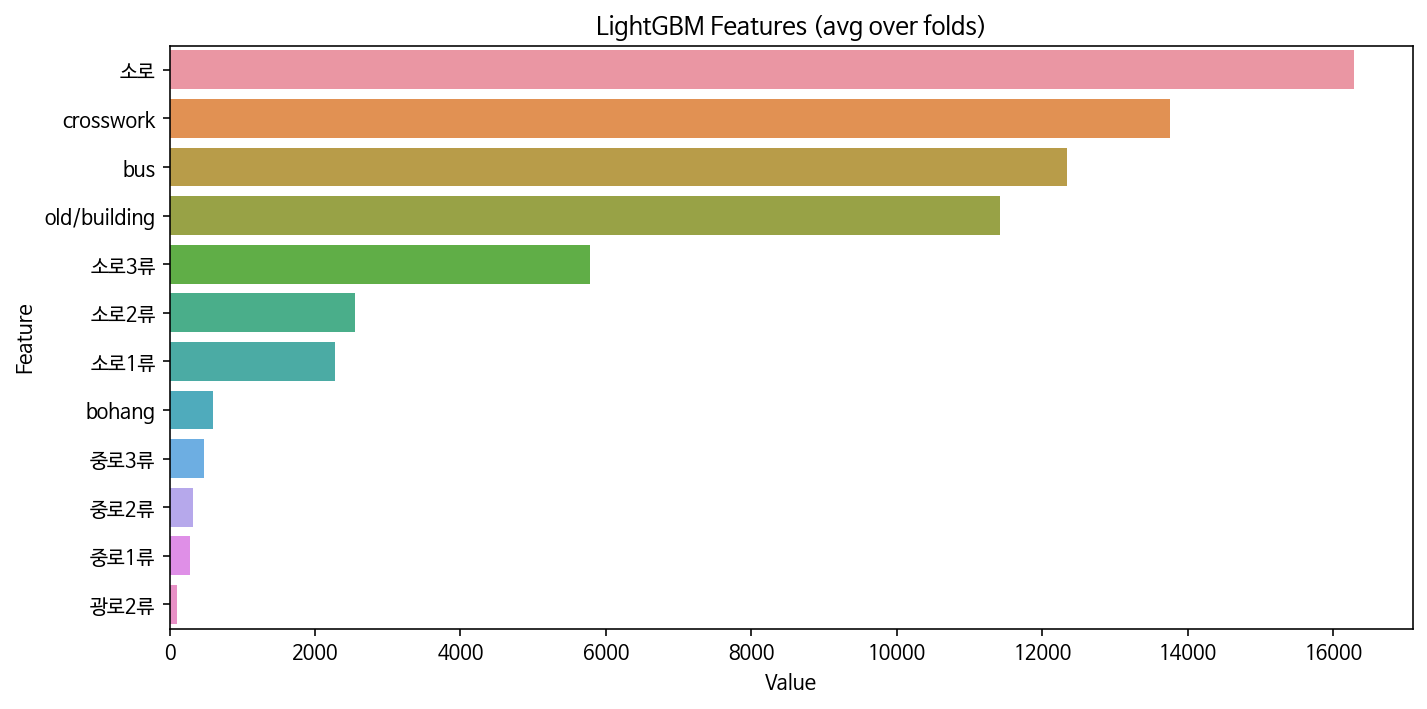

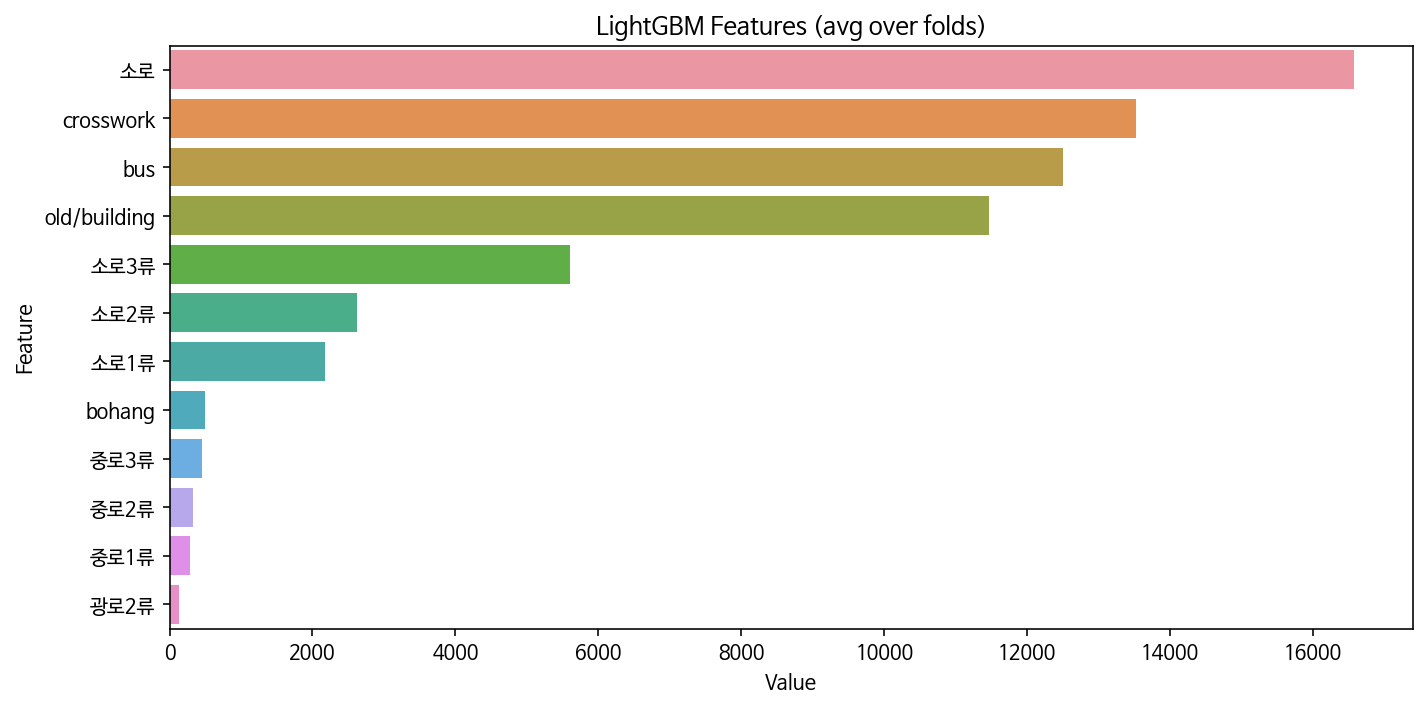

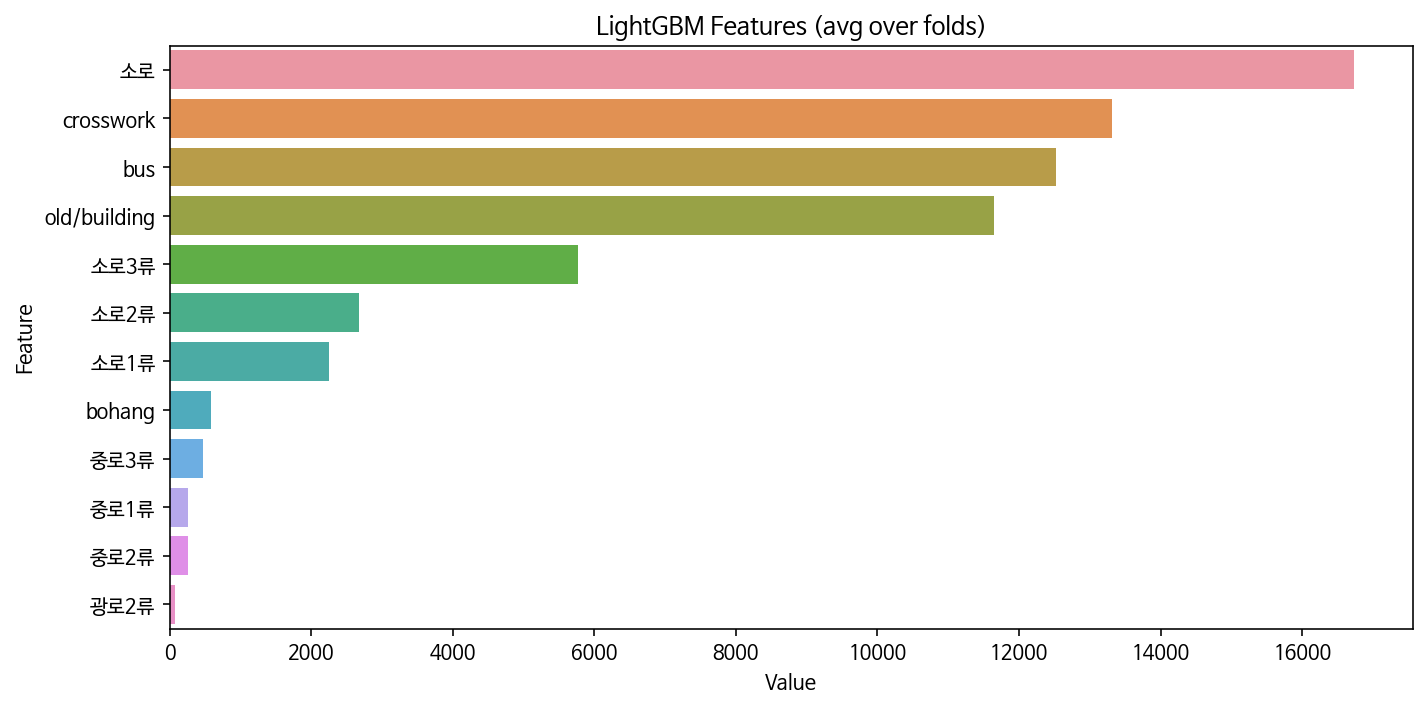

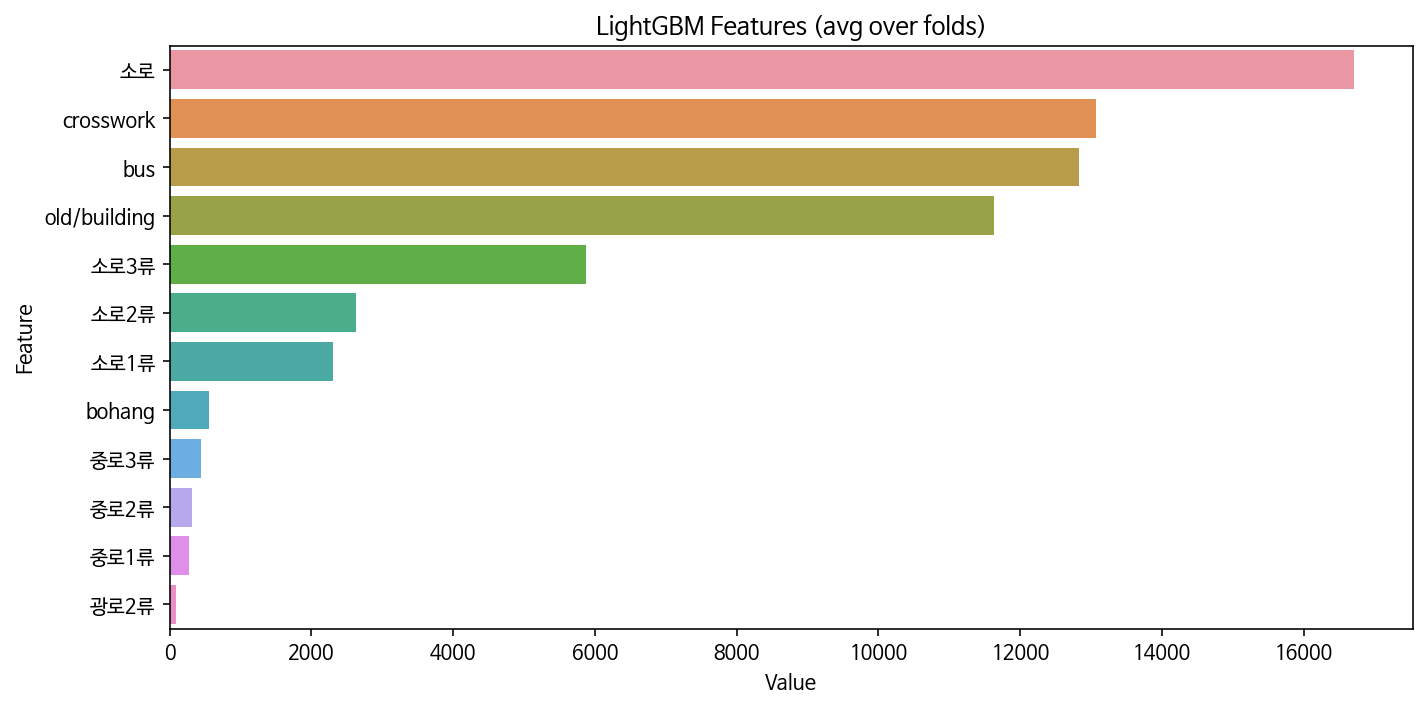

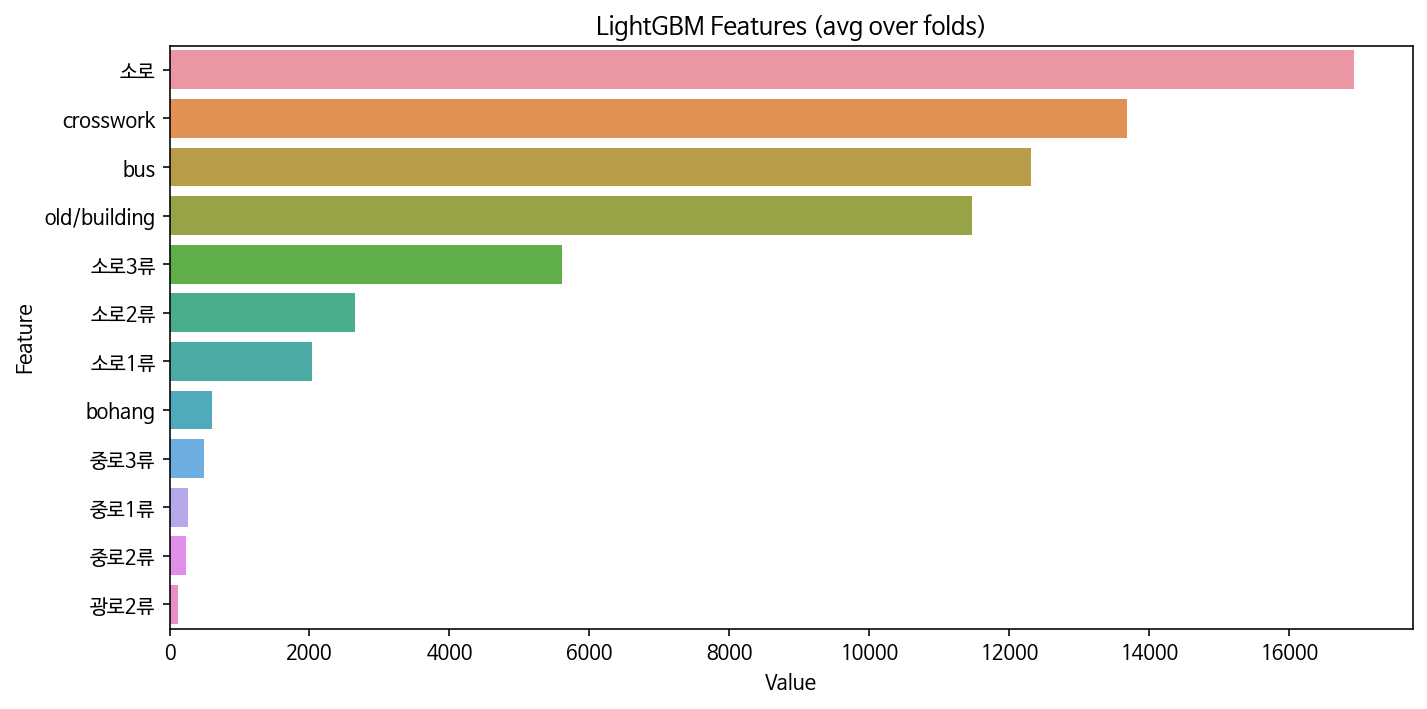

In [0]:
final_frame=pd.DataFrame()

for model in models:
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])
    plt.figure(figsize=(10, 5))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

    

In [0]:
feature_imp

,Value,Feature
0,117,광로2류
1,239,중로2류
2,261,중로1류
3,489,중로3류
4,611,bohang
5,2040,소로1류
6,2646,소로2류
7,5604,소로3류
8,11466,old/building
9,12310,bus


# 직사각형 5만, 유클리드: 150

In [0]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/공모전/동작구_공모전/sell_십만_250.csv',encoding='cp949')
data.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)

In [0]:
# 파생변수 제작
data['old/building'] = data['old_place']/data['building']
data['child/building'] = data['child_place']/data['building']

In [0]:
data.head()

,x,y,소로,중로2류,소로1류,소로3류,중로3류,소로2류,중로1류,광로2류,old_place,child_place,crosswork,building,bus,bohang,accident,old_acc,old/building,child/building
0,195600.888993,545928.299315,10,0,1,2,0,0,0,0,4.0,1.0,27.0,207.0,64.0,0.0,0.0,0.0,0.019324,0.004831
1,194062.308207,544725.091085,46,0,3,3,0,0,0,0,2.0,6.0,12.0,598.0,19.0,0.0,4.0,3.0,0.003344,0.010033
2,197377.867009,543986.683138,0,0,0,0,0,0,0,0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,193058.182323,543489.087262,0,0,0,0,0,0,0,0,0.0,2.0,4.0,22.0,0.0,0.0,0.0,0.0,0.000000,0.090909
4,197347.383013,542701.828076,50,0,0,7,0,0,0,0,6.0,4.0,18.0,637.0,10.0,0.0,2.0,2.0,0.009419,0.006279


In [0]:
# 이진분류
data.loc[data['old_acc']==0,'accident']=0
data.loc[data['old_acc']!=0,'accident']=1

In [0]:
X_train=data.drop(['x','y','accident','building','old_place','child_place','child/building','old_acc'],axis=1)
y_train=data['accident']

In [0]:
X_train.replace([np.inf, -np.inf], 0, inplace=True)
X_train.fillna(0,inplace=True)
#X_test.replace([np.inf, -np.inf], 0, inplace=True)
#X_test.fillna(0,inplace=True)

In [0]:
def lgb_cv(num_leaves, learning_rate, n_estimators, subsample, colsample_bytree, reg_alpha,reg_lambda, x_data=None, y_data=None, n_splits=5, output='model'):
    score = 0
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=201)
    models = []
    sm = SMOTE(ratio='auto', kind='regular')
    for train_index, valid_index in skf.split(x_data,y_data):
       #print(train_index)
       x_train, y_train = x_data.iloc[train_index], y_data.iloc[train_index]
       
       #Smote
       sm = SMOTE(ratio='auto', kind='regular')
       # train데이터를 넣어 복제함
       X_resampled, y_resampled = sm.fit_sample(x_train,y_train)
       x_valid, y_valid = x_data.iloc[valid_index], y_data.iloc[valid_index]
        
       model = lgb.LGBMClassifier(
               
           num_leaves = int(num_leaves), 
           learning_rate = learning_rate, 
           n_estimators = int(n_estimators), 
           subsample = np.clip(subsample, 0, 1), 
           colsample_bytree = np.clip(colsample_bytree, 0, 1), 
           reg_alpha = reg_alpha, 
           reg_lambda = reg_lambda,
           )
       
       model.fit(X_resampled, y_resampled)
       models.append(model)
        
       pred = model.predict_proba(x_valid)[:, 1]
       true = y_valid
       score += roc_auc_score(true, pred)/n_splits
    
    if output == 'score':
        return score
    if output == 'model':
        return models

In [0]:
func_fixed = partial(lgb_cv, x_data=X_train, y_data=y_train, n_splits=5, output='score') 

lgbBO = BayesianOptimization(
    func_fixed, 
    {
        'num_leaves': (16, 1024),
        'learning_rate': (0.0001, 0.1),
        'n_estimators': (16, 2048),#1024),
        'subsample': (0, 1),
        'colsample_bytree': (0, 1),
        'reg_alpha': (0, 10), 
        'reg_lambda': (0, 50),
    }, 
    random_state=4321
)
lgbBO.maximize(init_points=5, n_iter=5) #30

|   iter    |  target   | colsam... | learni... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.9161   |  0.0708   |  0.08152  |  1.576e+0 |  304.6    |  1.931    |  48.95    |  0.4062   |
|  2        |  0.9943   |  0.7578   |  0.009006 |  645.7    |  639.9    |  4.599    |  10.92    |  0.6635   |
|  3        |  0.997    |  0.6787   |  0.09504  |  587.5    |  640.8    |  3.833    |  20.02    |  0.9427   |
|  4        |  0.9967   |  0.9299   |  0.09484  |  779.0    |  361.0    |  6.648    |  2.116    |  0.2322   |
|  5        |  0.9952   |  0.4301   |  0.007886 |  1.574e+0 |  876.7    |  1.504    |  5.057    |  0.2709   |
|  6        |  0.9255   |  0.6222   |  0.03011  |  18.6     |  17.06    |  8.005    |  30.57    |  0.4728   |
|  7        |  0.9958   |  0.8807   |  0.06331  |  2.044e+0 |  1.013e+0 |  9.745    |  36.34    |  0.2119   |
|  8      

In [0]:
params = lgbBO.max['params']
models = lgb_cv(
    params['num_leaves'],   
    params['learning_rate'], 
    params['n_estimators'], 
    params['subsample'], 
    params['colsample_bytree'], 
    params['reg_alpha'], 
    params['reg_lambda'], 
    x_data=X_train, y_data=y_train, n_splits=5, output='model')

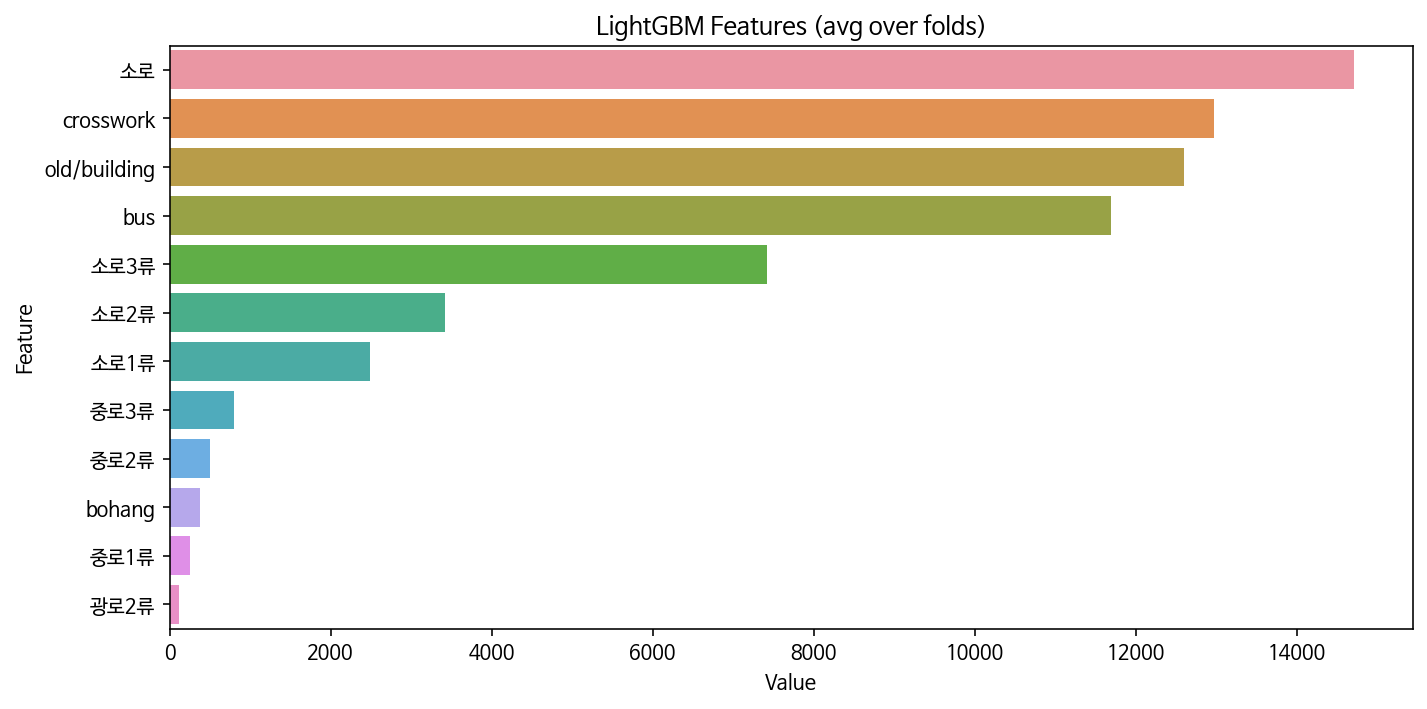

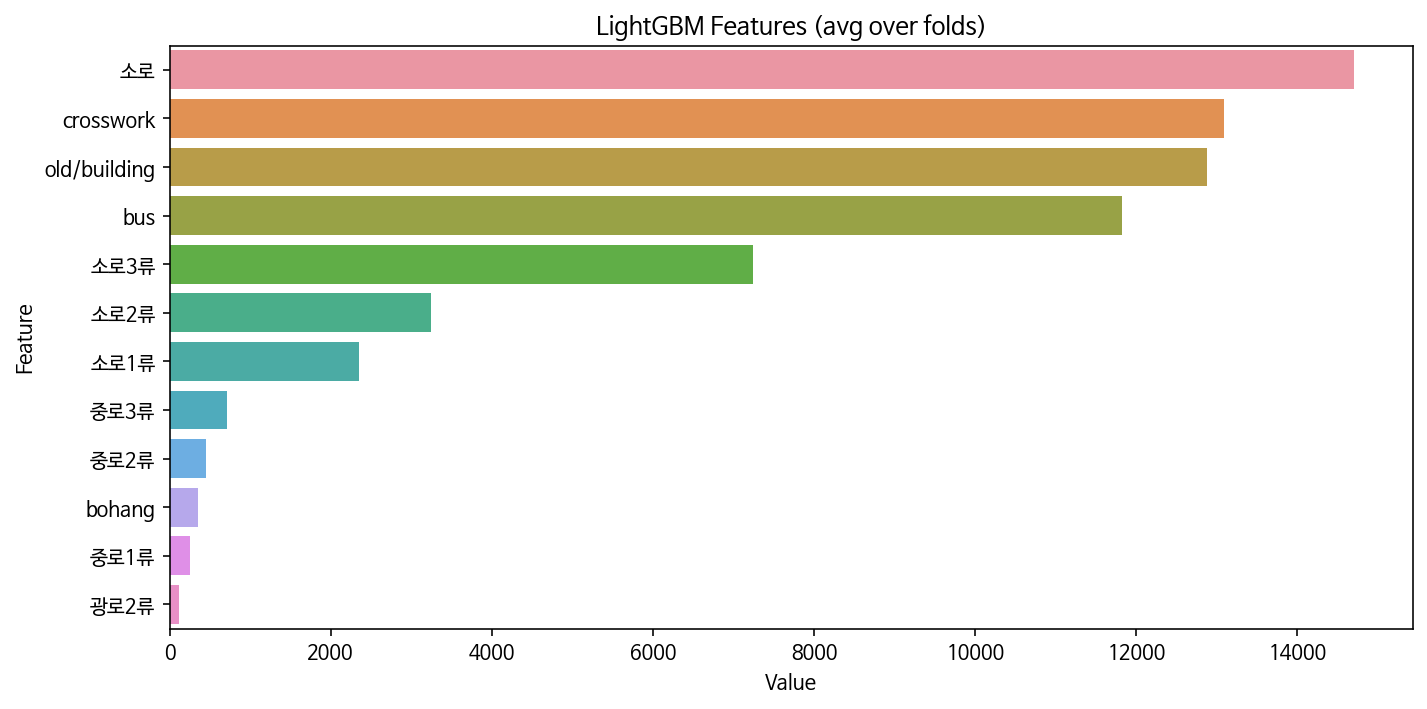

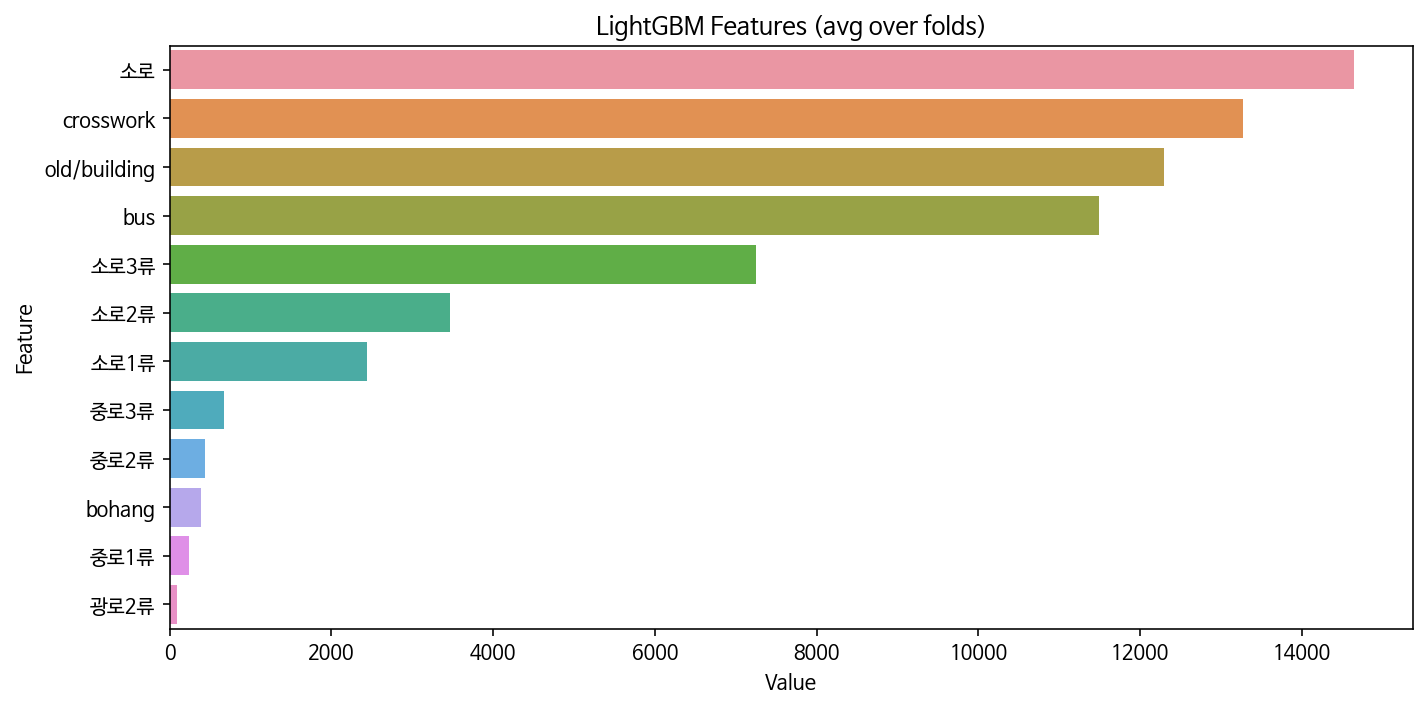

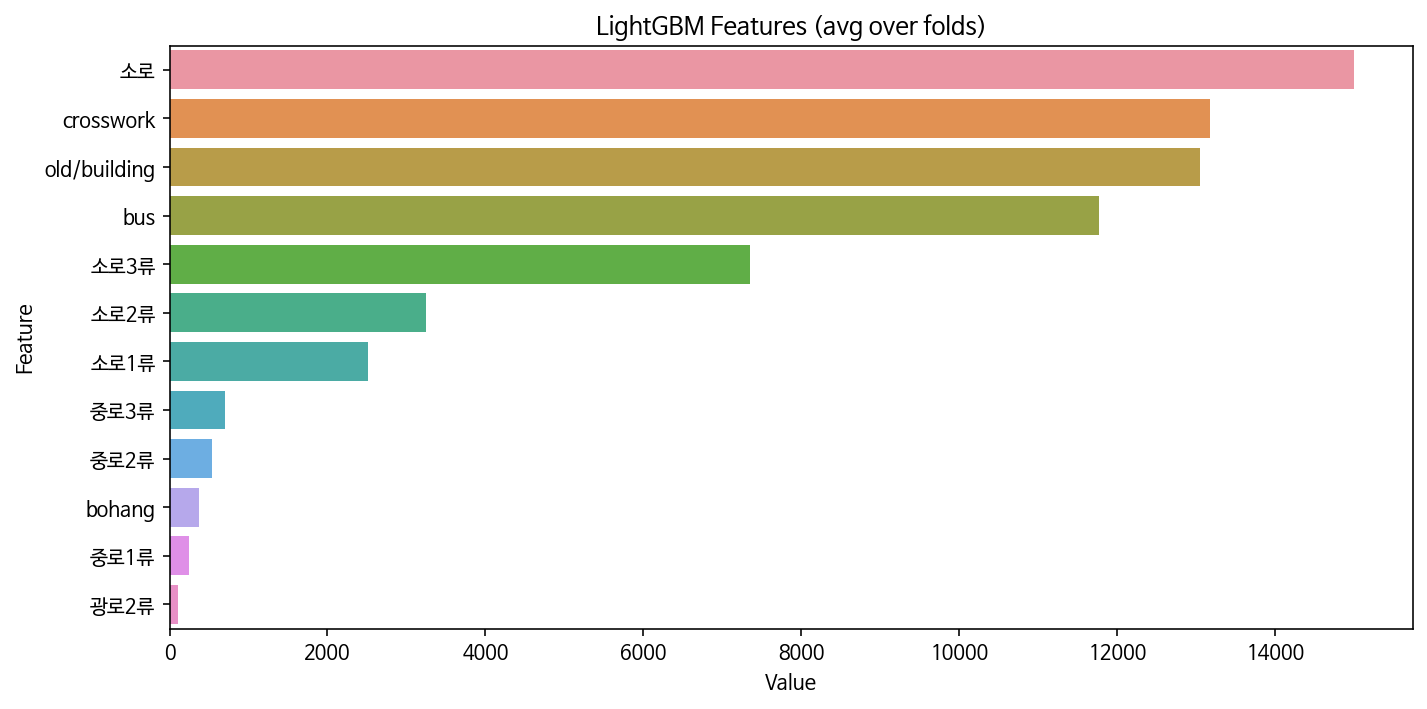

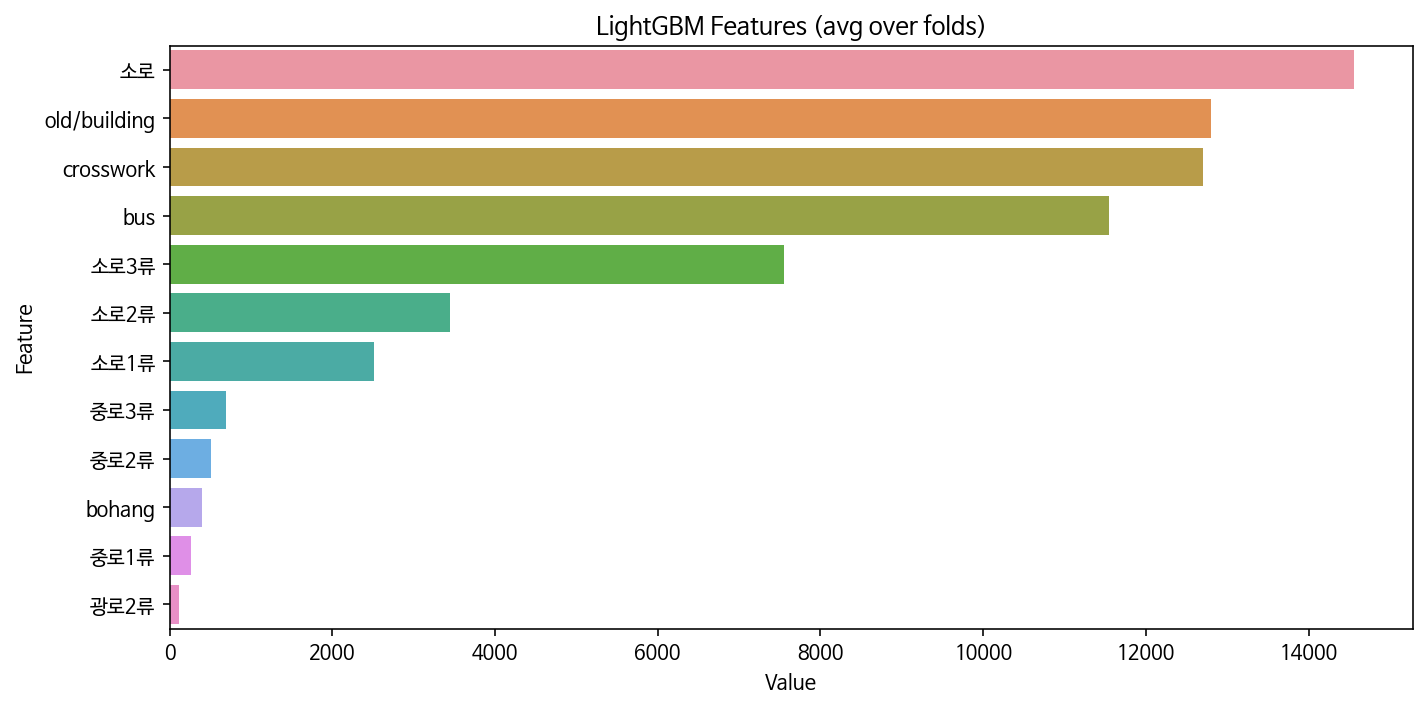

In [0]:
for model in models:
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])

    plt.figure(figsize=(10, 5))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()